In [1]:
!pip install scikit-learn

In [2]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
movies = pd.read_csv("/content/movies_metadata.csv")
ratings = pd.read_csv("/content/ratings_small.csv")

print(movies.head())
print(ratings.head())


   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

<ipython-input-4-fa3d333c00ed>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies = pd.read_csv("/content/movies_metadata.csv")


              userId        movieId         rating     timestamp
count  100004.000000  100004.000000  100004.000000  1.000040e+05
mean      347.011310   12548.664363       3.543608  1.129639e+09
std       195.163838   26369.198969       1.058064  1.916858e+08
min         1.000000       1.000000       0.500000  7.896520e+08
25%       182.000000    1028.000000       3.000000  9.658478e+08
50%       367.000000    2406.500000       4.000000  1.110422e+09
75%       520.000000    5418.000000       4.000000  1.296192e+09
max       671.000000  163949.000000       5.000000  1.476641e+09


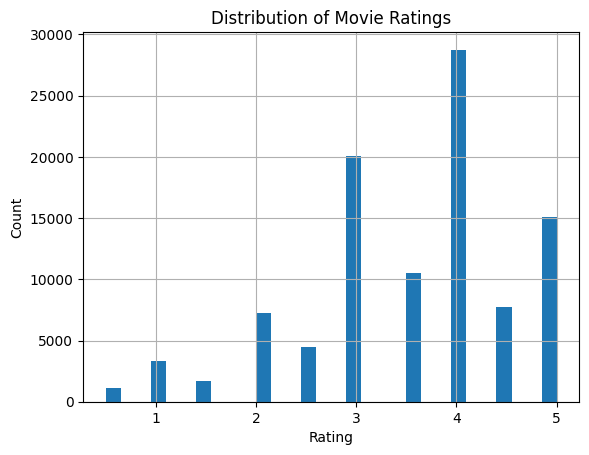

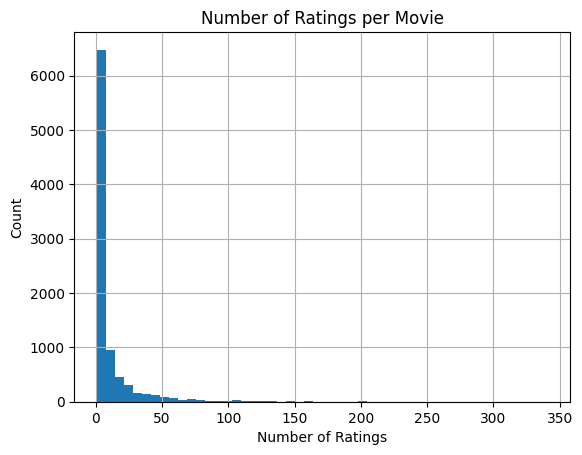

In [5]:
# Basic stats
print(ratings.describe())

# Histogram of ratings
ratings['rating'].hist(bins=30)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Ratings count per movie
ratings_per_movie = ratings.groupby('movieId').count()['rating']
ratings_per_movie.hist(bins=50)
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()


In [6]:
# Create user-movie matrix
user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)


In [7]:
# Normalize data
scaler = StandardScaler()
user_movie_matrix_scaled = scaler.fit_transform(user_movie_matrix)

# Compute cosine similarity
user_similarity_df = pd.DataFrame(
    cosine_similarity(user_movie_matrix_scaled),
    index=user_movie_matrix.index,
    columns=user_movie_matrix.index
)


In [8]:
def get_similar_users(user_id, n=5):
    return user_similarity_df[user_id].sort_values(ascending=False)[1:n+1].index

def recommend_movies(user_id, num_recommendations=5):
    similar_users = get_similar_users(user_id)
    similar_users_ratings = ratings[ratings['userId'].isin(similar_users)]
    user_movies = ratings[ratings['userId'] == user_id]['movieId'].tolist()

    recommended_movies = (
        similar_users_ratings[~similar_users_ratings['movieId'].isin(user_movies)]
        .groupby('movieId')
        .agg({'rating': 'mean'})
        .sort_values(by='rating', ascending=False)
        .head(num_recommendations)
        .reset_index()
    )

    return pd.merge(recommended_movies, movies, on='movieId')[['title', 'rating']]


In [13]:
recommendations = recommend_movies(user_id=1, num_recommendations=10)
print(recommendations)


                                title  rating
0                             Solaris     5.0
1  Terminator 3: Rise of the Machines     5.0
2                Sleepless in Seattle     5.0
3            Torrente 3 The Protector     4.5
4                    Live and Let Die     4.0
5                       Jurassic Park     4.0
6                      Ocean's Eleven     4.0
7                             48 Hrs.     4.0


In [10]:
print(movies.columns)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')


In [11]:
movies.rename(columns={'id': 'movieId'}, inplace=True)


In [12]:
movies['movieId'] = pd.to_numeric(movies['movieId'], errors='coerce')


In [15]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/recommend', methods=['POST'])
def recommend():
    data = request.get_json(force=True)
    user_id = data['user_id']
    num_recommendations = data.get('num_recommendations', 10)

    recommendations = recommend_movies(user_id, num_recommendations)

    return jsonify(recommendations.to_dict(orient='records'))

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
